# 【数据分析】淘宝用户行为分析

基于淘宝用户行为数据，从以下几个方面分析：
* 收藏量、支付行为在双十二前后的走势情况
* 用户收藏产品后续实际购买率
* 哪些产品有cross-sale效应
* 使用RFM模型对用户进行分层，并找到核心用户

- 算法概述：使用Apriori算法试图找到交叉销售的规则。RFM模型是此次重点分析内容。使用常规方法手动划分客户集群，同时也利用K-Means聚类算法，以希望找到最好的集群划分，让我们在制定销售策略时，目标更具有针对性。

## 1.数据处理

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# 读取数据
df=pd.read_csv('G:\\1python\\鲸鱼社区\\20210219_淘宝行为用户分析\\淘宝用户行为.csv')
df.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time
0,98047837,232431562,1,NaN,4245,2014-12-06 02
1,97726136,383583590,1,NaN,5894,2014-12-09 20
2,98607707,64749712,1,NaN,2883,2014-12-18 11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10
4,98145908,290208520,1,NaN,13926,2014-12-16 21


In [3]:
# 将time列拆分为date列和hour列
df['date']=df['time'].str.split(' ').str[0]
df['hour']=df['time'].str.split(' ').str[1]

#将time列和date列转化为日期类数据类型，将hour列转化为整数类型
df['time']=pd.to_datetime(df['time'])
df['date']=pd.to_datetime(df['date'])
df['hour']=df['hour'].astype('int')

In [4]:
df.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,98047837,232431562,1,NaN,4245,2014-12-06 02:00:00,2014-12-06,2
1,97726136,383583590,1,NaN,5894,2014-12-09 20:00:00,2014-12-09,20
2,98607707,64749712,1,NaN,2883,2014-12-18 11:00:00,2014-12-18,11
3,98662432,320593836,1,96nn52n,6562,2014-12-06 10:00:00,2014-12-06,10
4,98145908,290208520,1,NaN,13926,2014-12-16 21:00:00,2014-12-16,21


In [5]:
#查看数据集的时间范围
print('时间序列共有{}天'.format((df['date'].max()-df['date'].min()).days))

# 开始时间和结束时间
start_date=df['date'].min()
end_date=df['date'].max()
print('开始时间：',start_date)
print('结束时间：',end_date)

时间序列共有30天
开始时间： 2014-11-18 00:00:00
结束时间： 2014-12-18 00:00:00


## 2.收藏量在双十二前后的走势情况


In [6]:
grouping_count=df[df.behavior_type==2].groupby('date').count()
grouping_count.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,hour
date,,,,,,,
2014-11-18,6904,6904,6904,1835,6904,6904,6904
2014-11-19,7152,7152,7152,2100,7152,7152,7152
2014-11-20,7167,7167,7167,1954,7167,7167,7167
2014-11-21,6832,6832,6832,1836,6832,6832,6832
2014-11-22,7252,7252,7252,1915,7252,7252,7252


In [7]:
grouping_count.index

DatetimeIndex(['2014-11-18', '2014-11-19', '2014-11-20', '2014-11-21',
               '2014-11-22', '2014-11-23', '2014-11-24', '2014-11-25',
               '2014-11-26', '2014-11-27', '2014-11-28', '2014-11-29',
               '2014-11-30', '2014-12-01', '2014-12-02', '2014-12-03',
               '2014-12-04', '2014-12-05', '2014-12-06', '2014-12-07',
               '2014-12-08', '2014-12-09', '2014-12-10', '2014-12-11',
               '2014-12-12', '2014-12-13', '2014-12-14', '2014-12-15',
               '2014-12-16', '2014-12-17', '2014-12-18'],
              dtype='datetime64[ns]', name='date', freq=None)

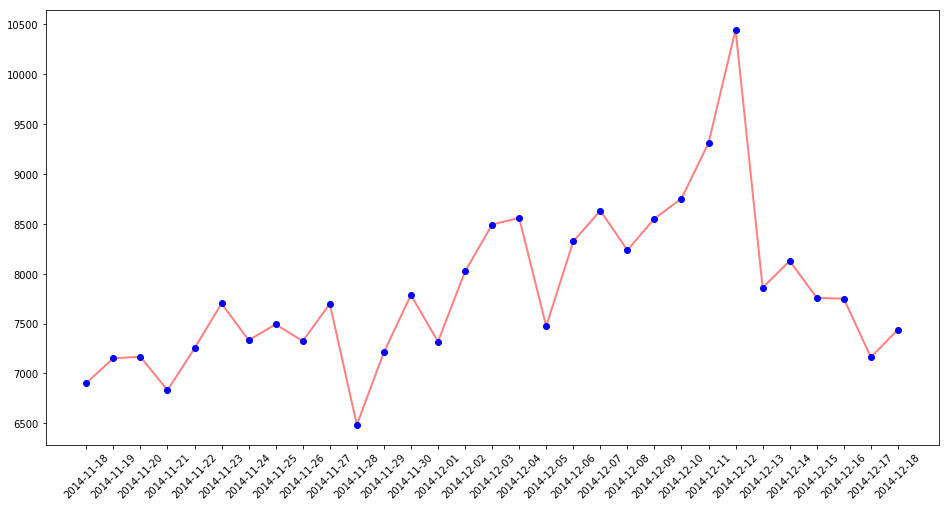

In [8]:
plt.figure(figsize=(16,8))
x=['2014-11-18', '2014-11-19', '2014-11-20', '2014-11-21',
               '2014-11-22', '2014-11-23', '2014-11-24', '2014-11-25',
               '2014-11-26', '2014-11-27', '2014-11-28', '2014-11-29',
               '2014-11-30', '2014-12-01', '2014-12-02', '2014-12-03',
               '2014-12-04', '2014-12-05', '2014-12-06', '2014-12-07',
               '2014-12-08', '2014-12-09', '2014-12-10', '2014-12-11',
               '2014-12-12', '2014-12-13', '2014-12-14', '2014-12-15',
               '2014-12-16', '2014-12-17', '2014-12-18']
y=grouping_count['user_id']
plt.plot(x,y,'r',linewidth=2,alpha=0.5)
plt.plot(x,y,'bo')
plt.xticks(x,rotation=45)
plt.show()

由上图可以看出：
* 双十二之前的收藏量每天都有波动，但整体呈上升趋势
* 双十二当天达到了峰值
* 双十二过后，收藏量也迅速下降

## 3.支付行为在双十二前后的走势情况

In [9]:
grouping_count=df[df.behavior_type==4].groupby('date').count()
grouping_count.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,hour
date,,,,,,,
2014-11-18,3730,3730,3730,1062,3730,3730,3730
2014-11-19,3686,3686,3686,1170,3686,3686,3686
2014-11-20,3462,3462,3462,944,3462,3462,3462
2014-11-21,3021,3021,3021,811,3021,3021,3021
2014-11-22,3570,3570,3570,892,3570,3570,3570


In [10]:
grouping_count.index

DatetimeIndex(['2014-11-18', '2014-11-19', '2014-11-20', '2014-11-21',
               '2014-11-22', '2014-11-23', '2014-11-24', '2014-11-25',
               '2014-11-26', '2014-11-27', '2014-11-28', '2014-11-29',
               '2014-11-30', '2014-12-01', '2014-12-02', '2014-12-03',
               '2014-12-04', '2014-12-05', '2014-12-06', '2014-12-07',
               '2014-12-08', '2014-12-09', '2014-12-10', '2014-12-11',
               '2014-12-12', '2014-12-13', '2014-12-14', '2014-12-15',
               '2014-12-16', '2014-12-17', '2014-12-18'],
              dtype='datetime64[ns]', name='date', freq=None)

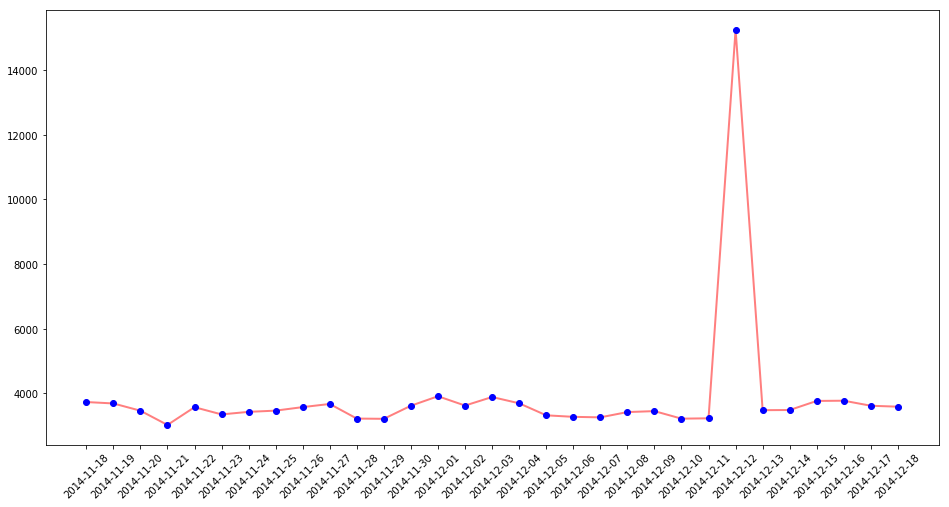

In [11]:
# 可视化
plt.figure(figsize=(16,8))
x=['2014-11-18', '2014-11-19', '2014-11-20', '2014-11-21',
               '2014-11-22', '2014-11-23', '2014-11-24', '2014-11-25',
               '2014-11-26', '2014-11-27', '2014-11-28', '2014-11-29',
               '2014-11-30', '2014-12-01', '2014-12-02', '2014-12-03',
               '2014-12-04', '2014-12-05', '2014-12-06', '2014-12-07',
               '2014-12-08', '2014-12-09', '2014-12-10', '2014-12-11',
               '2014-12-12', '2014-12-13', '2014-12-14', '2014-12-15',
               '2014-12-16', '2014-12-17', '2014-12-18']
y=grouping_count['user_id']
plt.plot(x,y,'r',linewidth=2,alpha=0.5)
plt.plot(x,y,'bo')
plt.xticks(x,rotation=45)
plt.show()

从上图可以看出，双十二的支付行为明显超出了平常的时间，顾客更愿意在双十二当天付款。支付行为曲线可以看出大家平常的支付行为处于一个比较稳定的状态，建议平常也应该有一些活动刺激用户消费，比如每周抽出一天，作为周消费日，这一天可以加大折扣力度，刺激大家的日常消费。

## 4.用户收藏产品和加入购物车后的实际购买率

In [12]:
collect_to_pay=df.groupby(['behavior_type']).count().reset_index()
collect_to_pay

,behavior_type,user_id,item_id,user_geohash,item_category,time,date,hour
0,1,11550581,11550581,3704666,11550581,11550581,11550581,11550581
1,2,242556,242556,74365,242556,242556,242556,242556
2,3,343564,343564,104443,343564,343564,343564,343564
3,4,120205,120205,38608,120205,120205,120205,120205


In [13]:
print('用户收藏-->用户支付:{:.3f}'.format(collect_to_pay.iloc[3,1]/collect_to_pay.iloc[1,1]))
print('加购物车-->用户支付:{:.3f}'.format(collect_to_pay.iloc[3,1]/collect_to_pay.iloc[2,1]))

用户收藏-->用户支付:0.496
加购物车-->用户支付:0.350


如果说用户收藏和加购物车哪一种行为会导致最后的购买，大部分人应该会觉得是加入购物车，但从计算结果看并不是这样。当然这种计算方式是比较粗略的估计方法。

## 5.哪些产品有CrossSale效应

按照关联技术（Association Analysis），也即通常所说的购物篮分析，发现那些有较大可能被一起采购的商品，将它们进行有针对的促销的捆绑，这就是交叉销售。“啤酒和尿布”的故事说的正是这种交叉销售效应。下面将使用Apriori算法来进行分析。

In [14]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

根据所提供的数据，下面的分析基于一个假设前提，即同一用户在同一时间内所购买的物品具有关联性，我们希望找出这样的关联规则。

In [15]:
# group by user_id and time
grouped=df[df.behavior_type==4].groupby(['user_id','time'])
# 展示每个用户在同一时间购买的unique商品
result=grouped['item_id'].unique()

In [16]:
result

user_id    time               
4913       2014-12-01 23:00:00                                          [343170253]
           2014-12-07 22:00:00                                           [44957435]
           2014-12-11 18:00:00                                          [172639700]
           2014-12-13 18:00:00                                           [92674121]
           2014-12-16 12:00:00                                          [361346418]
6118       2014-12-17 21:00:00                                          [166345818]
7528       2014-11-22 13:00:00                                           [28240903]
           2014-11-26 21:00:00                                          [200106437]
           2014-11-27 21:00:00                                          [374890725]
           2014-11-30 15:00:00                                            [9836185]
           2014-12-03 22:00:00                                          [370232831]
           2014-12-13 19:00:00               

In [17]:
result2=result.reset_index()

In [18]:
result2

,user_id,time,item_id
0,4913,2014-12-01 23:00:00,[343170253]
1,4913,2014-12-07 22:00:00,[44957435]
2,4913,2014-12-11 18:00:00,[172639700]
3,4913,2014-12-13 18:00:00,[92674121]
4,4913,2014-12-16 12:00:00,[361346418]
5,6118,2014-12-17 21:00:00,[166345818]
6,7528,2014-11-22 13:00:00,[28240903]
7,7528,2014-11-26 21:00:00,[200106437]
8,7528,2014-11-27 21:00:00,[374890725]
9,7528,2014-11-30 15:00:00,[9836185]


In [19]:
# 计算每个用户在同一时间购买不同物品的个数
result2['count']=result2['item_id'].apply(lambda x:len(x))

In [20]:
result2

,user_id,time,item_id,count
0,4913,2014-12-01 23:00:00,[343170253],1
1,4913,2014-12-07 22:00:00,[44957435],1
2,4913,2014-12-11 18:00:00,[172639700],1
3,4913,2014-12-13 18:00:00,[92674121],1
4,4913,2014-12-16 12:00:00,[361346418],1
5,6118,2014-12-17 21:00:00,[166345818],1
6,7528,2014-11-22 13:00:00,[28240903],1
7,7528,2014-11-26 21:00:00,[200106437],1
8,7528,2014-11-27 21:00:00,[374890725],1
9,7528,2014-11-30 15:00:00,[9836185],1


In [21]:
result2['item_basket']=result2['item_id'].apply(lambda x:str(x).replace('[','').replace(']',''))

In [22]:
result2['item_count']=1
result2.head()

,user_id,time,item_id,count,item_basket,item_count
0,4913,2014-12-01 23:00:00,[343170253],1,343170253,1
1,4913,2014-12-07 22:00:00,[44957435],1,44957435,1
2,4913,2014-12-11 18:00:00,[172639700],1,172639700,1
3,4913,2014-12-13 18:00:00,[92674121],1,92674121,1
4,4913,2014-12-16 12:00:00,[361346418],1,361346418,1


In [23]:
# str.strip()就是把字符串(str)的头和尾的空格，以及位于头尾的\n \t之类给删掉
result2['item_basket']=result2['item_basket'].str.strip()
result2.dropna(axis=0,subset=['user_id'],inplace=True)
result2['user_id']=result2['user_id'].astype('str')
result2.head()

,user_id,time,item_id,count,item_basket,item_count
0,4913,2014-12-01 23:00:00,[343170253],1,343170253,1
1,4913,2014-12-07 22:00:00,[44957435],1,44957435,1
2,4913,2014-12-11 18:00:00,[172639700],1,172639700,1
3,4913,2014-12-13 18:00:00,[92674121],1,92674121,1
4,4913,2014-12-16 12:00:00,[361346418],1,361346418,1


限于计算资源，我们这里仅使用前50行数据

In [24]:
result3=result2.iloc[0:50]
result3.head(50)

,user_id,time,item_id,count,item_basket,item_count
0,4913,2014-12-01 23:00:00,[343170253],1,343170253,1
1,4913,2014-12-07 22:00:00,[44957435],1,44957435,1
2,4913,2014-12-11 18:00:00,[172639700],1,172639700,1
3,4913,2014-12-13 18:00:00,[92674121],1,92674121,1
4,4913,2014-12-16 12:00:00,[361346418],1,361346418,1
5,6118,2014-12-17 21:00:00,[166345818],1,166345818,1
6,7528,2014-11-22 13:00:00,[28240903],1,28240903,1
7,7528,2014-11-26 21:00:00,[200106437],1,200106437,1
8,7528,2014-11-27 21:00:00,[374890725],1,374890725,1
9,7528,2014-11-30 15:00:00,[9836185],1,9836185,1


In [25]:
# 转化成basket的形式
basket=result3.groupby(['user_id','item_basket'])['item_count'].sum().unstack().reset_index().fillna(0).set_index('user_id')
basket

item_basket,109945617 61223475,118440053,166345818,172639700,176492645,176556528,187543694 50088248 386542834 10230733,200106437,215135446,221738362,...,401255397,404235535 48485652,44957435,50490022 215070970 93945127,67695181,84482071 235689238,92674121,93202448 38268433 240166258 124130706,94465435,9836185
user_id,,,,,,,,,,,,,,,,,,,,,
12645,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4913,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
54056,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6118,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
63348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7528,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
7591,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
79824,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
88930,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [26]:
def encode_units(x):
    if x<=0:
        return 0
    if x>=1:
        return 1
basket_sets=basket.applymap(encode_units)
basket_sets

item_basket,109945617 61223475,118440053,166345818,172639700,176492645,176556528,187543694 50088248 386542834 10230733,200106437,215135446,221738362,...,401255397,404235535 48485652,44957435,50490022 215070970 93945127,67695181,84482071 235689238,92674121,93202448 38268433 240166258 124130706,94465435,9836185
user_id,,,,,,,,,,,,,,,,,,,,,
12645,0,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4913,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
54056,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6118,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
63348,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7528,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
7591,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,1,0,0
79824,1,0,0,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
88930,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,1,0


In [27]:
# 计算频繁集
frequent_itemsets=apriori(basket_sets,min_support=0.01,use_colnames=True)
frequent_itemsets.head(15)

,support,itemsets
0,0.111111,(109945617 61223475)
1,0.111111,(118440053)
2,0.111111,(166345818)
3,0.111111,(172639700)
4,0.111111,(176492645)
5,0.111111,(176556528)
6,0.111111,(187543694 50088248 386542834 10230733)
7,0.111111,(200106437)
8,0.111111,(215135446)
9,0.111111,(221738362)


In [28]:
# 产生关联规则
rules=association_rules(frequent_itemsets,metric='confidence',min_threshold=0.0001)
rules.head(15)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(109945617 61223475),(176492645),0.111111,0.111111,0.111111,1.0,9.0,0.098765,inf
1,(176492645),(109945617 61223475),0.111111,0.111111,0.111111,1.0,9.0,0.098765,inf
2,(109945617 61223475),(253349162),0.111111,0.111111,0.111111,1.0,9.0,0.098765,inf
3,(253349162),(109945617 61223475),0.111111,0.111111,0.111111,1.0,9.0,0.098765,inf
4,(109945617 61223475),(264424578),0.111111,0.111111,0.111111,1.0,9.0,0.098765,inf
5,(264424578),(109945617 61223475),0.111111,0.111111,0.111111,1.0,9.0,0.098765,inf
6,(273369408),(109945617 61223475),0.111111,0.111111,0.111111,1.0,9.0,0.098765,inf
7,(109945617 61223475),(273369408),0.111111,0.111111,0.111111,1.0,9.0,0.098765,inf
8,(109945617 61223475),(301934779),0.111111,0.111111,0.111111,1.0,9.0,0.098765,inf
9,(301934779),(109945617 61223475),0.111111,0.111111,0.111111,1.0,9.0,0.098765,inf


In [29]:
# 选择满足条件的规则
rules[(rules['lift']>9)&(rules['confidence']>1)]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction


通过最后的计算结果我们能够发现一些问题，最后所有的关联规则好像没什么区别。如果这些规则都没有区别的话，实际应用中几乎没有任何指导意义。
* 一方面是因为这里受限于计算资源，选择的数据不全面
* 另一方面，所提供的数据确实也存在着一些问题。产品的品类（item_id）有很多，但用户与用户之间购买的商品确实也存在关联性不大的可能。

在这些情况下，如果提供的数据量更大，时间序列横跨更长（不仅仅是这里的30天），用户数更多，并且计算资源足够，是能够得到非常具有实际意义指导商品交易的关联规则。

## 6.同期群分析（cohort analysis）

将相同时间段内具有共同行为特征的用户划分为同一群体，其被称为同期群。“共同行为特征”是指在某个时间段内的行为相似。最常见的是按不同时间的新增用户来划分，然后分析留存率。它可以提供有关商品和客户生命周期的信息。

同期群分析共有三种类型：
* 时间同类：在一段时间内，将客户按购买行为分组。
* 行为同类：按客户购买的产品或服务对客户进行分组。
* 规模同类：指购买公司产品或服务的各种规模的客户。此分类可以基于一段时间内的支出金额。

了解各种同类群体的需求可以帮助公司设计针对特定细分市场的定制服务或产品。在下面的分析中，将创建“时间同类”群组，并查看在特定同类群组中在一段时间内保持活跃的客户。

In [30]:
cohort_data=df.loc[df['behavior_type']==4,:]
cohort_data.reset_index(drop=True,inplace=True)
cohort_data.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,101260672,73008997,4,NaN,4076,2014-11-25 13:00:00,2014-11-25,13
1,116730636,85319721,4,NaN,10079,2014-12-17 11:00:00,2014-12-17,11
2,104811265,61764614,4,NaN,675,2014-12-01 13:00:00,2014-12-01,13
3,106230218,238910858,4,NaN,12090,2014-12-03 11:00:00,2014-12-03,11
4,100684618,271840783,4,NaN,12220,2014-11-23 18:00:00,2014-11-23,18


In [31]:
grouping=cohort_data.groupby('user_id')['date']
#找到分组的最小值，然后将其赋值给整个组，这里表示第一次交易的时间
cohort_data['cohortdate']=grouping.transform('min')
cohort_data

C:\Users\GDM\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour,cohortdate
0,101260672,73008997,4,NaN,4076,2014-11-25 13:00:00,2014-11-25,13,2014-11-25
1,116730636,85319721,4,NaN,10079,2014-12-17 11:00:00,2014-12-17,11,2014-11-21
2,104811265,61764614,4,NaN,675,2014-12-01 13:00:00,2014-12-01,13,2014-12-01
3,106230218,238910858,4,NaN,12090,2014-12-03 11:00:00,2014-12-03,11,2014-11-26
4,100684618,271840783,4,NaN,12220,2014-11-23 18:00:00,2014-11-23,18,2014-11-18
5,106230218,127830564,4,NaN,2993,2014-12-15 15:00:00,2014-12-15,15,2014-11-26
6,106230218,296314097,4,NaN,552,2014-12-11 17:00:00,2014-12-11,17,2014-11-26
7,100684618,323189786,4,NaN,13598,2014-12-15 22:00:00,2014-12-15,22,2014-11-18
8,116730636,283854869,4,NaN,9001,2014-12-17 11:00:00,2014-12-17,11,2014-11-21
9,103802946,9205918,4,NaN,1877,2014-12-16 19:00:00,2014-12-16,19,2014-11-30


In [32]:
cohort_data['cohortIndex']=cohort_data['date']-cohort_data['cohortdate']
cohort_data['cohortIndex']=cohort_data['cohortIndex'].map(lambda x:x.days)
cohort_data.head()

C:\Users\GDM\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\GDM\Anaconda3\envs\tf-gpu\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour,cohortdate,cohortIndex
0,101260672,73008997,4,NaN,4076,2014-11-25 13:00:00,2014-11-25,13,2014-11-25,0
1,116730636,85319721,4,NaN,10079,2014-12-17 11:00:00,2014-12-17,11,2014-11-21,26
2,104811265,61764614,4,NaN,675,2014-12-01 13:00:00,2014-12-01,13,2014-12-01,0
3,106230218,238910858,4,NaN,12090,2014-12-03 11:00:00,2014-12-03,11,2014-11-26,7
4,100684618,271840783,4,NaN,12220,2014-11-23 18:00:00,2014-11-23,18,2014-11-18,5


In [33]:
grouping=cohort_data.groupby(['cohortdate','cohortIndex'])
cohort_data=grouping['user_id'].apply(pd.Series.nunique)
cohort_data=cohort_data.reset_index()
cohort_data

,cohortdate,cohortIndex,user_id
0,2014-11-18,0,1539
1,2014-11-18,1,445
2,2014-11-18,2,408
3,2014-11-18,3,352
4,2014-11-18,4,368
5,2014-11-18,5,361
6,2014-11-18,6,384
7,2014-11-18,7,396
8,2014-11-18,8,363
9,2014-11-18,9,381


In [34]:
cohort_counts=cohort_data.pivot(index='cohortdate',columns='cohortIndex',values='user_id')
cohort_counts

cohortIndex,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
cohortdate,,,,,,,,,,,,,,,,,,,,,
2014-11-18,1539.0,445.0,408.0,352.0,368.0,361.0,384.0,396.0,363.0,381.0,...,324.0,330.0,335.0,816.0,357.0,340.0,373.0,369.0,371.0,325.0
2014-11-19,1066.0,307.0,227.0,218.0,221.0,264.0,229.0,236.0,234.0,229.0,...,193.0,193.0,507.0,212.0,220.0,235.0,228.0,221.0,231.0,NaN
2014-11-20,777.0,181.0,162.0,145.0,141.0,161.0,161.0,152.0,157.0,133.0,...,139.0,357.0,142.0,141.0,161.0,163.0,139.0,164.0,NaN,NaN
2014-11-21,570.0,123.0,127.0,129.0,91.0,108.0,112.0,116.0,93.0,119.0,...,257.0,113.0,98.0,105.0,120.0,113.0,112.0,NaN,NaN,NaN
2014-11-22,540.0,110.0,88.0,100.0,99.0,100.0,90.0,84.0,108.0,101.0,...,88.0,78.0,83.0,85.0,98.0,93.0,NaN,NaN,NaN,NaN
2014-11-23,472.0,99.0,101.0,72.0,75.0,61.0,69.0,84.0,94.0,90.0,...,72.0,84.0,85.0,75.0,77.0,NaN,NaN,NaN,NaN,NaN
2014-11-24,419.0,87.0,82.0,61.0,68.0,63.0,63.0,89.0,57.0,67.0,...,75.0,75.0,78.0,66.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-25,332.0,67.0,61.0,54.0,41.0,55.0,61.0,54.0,50.0,43.0,...,57.0,43.0,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-26,299.0,63.0,45.0,44.0,41.0,49.0,48.0,54.0,47.0,53.0,...,45.0,33.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


对于cohortdate 2014-11-18：
* cohortIndex0，表明从2014-11-18到2014-12-18，有1539个客户在2014-11-18进行了首次交易
* cohortIndex1，表明1539个客户中有445个客户在2014-11-18日进行了首次交易，并且在第2天也进行了交易。即这些用户保持活跃。
* cohortIndex2，表明1539个客户中有445个客户在2014-11-18日进行了首次交易，并且在第3天也进行了交易。

现在计算保留率。它定义为活跃客户占总客户的百分比。由于每个群组中的活跃客户数量对应于CohortIndex0，因此我们将数据的第一列作为群组规模。

In [35]:
cohort_sizes=cohort_counts.iloc[:,0]
retention=cohort_counts.divide(cohort_sizes,axis=0)
retention.round(3)*100
retention

cohortIndex,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
cohortdate,,,,,,,,,,,,,,,,,,,,,
2014-11-18,1.0,0.289149,0.265107,0.228720,0.239116,0.234568,0.249513,0.257310,0.235867,0.247563,...,0.210526,0.214425,0.217674,0.530214,0.231969,0.220923,0.242365,0.239766,0.241066,0.211176
2014-11-19,1.0,0.287992,0.212946,0.204503,0.207317,0.247655,0.214822,0.221388,0.219512,0.214822,...,0.181051,0.181051,0.475610,0.198874,0.206379,0.220450,0.213884,0.207317,0.216698,NaN
2014-11-20,1.0,0.232947,0.208494,0.186615,0.181467,0.207207,0.207207,0.195624,0.202059,0.171171,...,0.178893,0.459459,0.182754,0.181467,0.207207,0.209781,0.178893,0.211068,NaN,NaN
2014-11-21,1.0,0.215789,0.222807,0.226316,0.159649,0.189474,0.196491,0.203509,0.163158,0.208772,...,0.450877,0.198246,0.171930,0.184211,0.210526,0.198246,0.196491,NaN,NaN,NaN
2014-11-22,1.0,0.203704,0.162963,0.185185,0.183333,0.185185,0.166667,0.155556,0.200000,0.187037,...,0.162963,0.144444,0.153704,0.157407,0.181481,0.172222,NaN,NaN,NaN,NaN
2014-11-23,1.0,0.209746,0.213983,0.152542,0.158898,0.129237,0.146186,0.177966,0.199153,0.190678,...,0.152542,0.177966,0.180085,0.158898,0.163136,NaN,NaN,NaN,NaN,NaN
2014-11-24,1.0,0.207637,0.195704,0.145585,0.162291,0.150358,0.150358,0.212411,0.136038,0.159905,...,0.178998,0.178998,0.186158,0.157518,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-25,1.0,0.201807,0.183735,0.162651,0.123494,0.165663,0.183735,0.162651,0.150602,0.129518,...,0.171687,0.129518,0.129518,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-26,1.0,0.210702,0.150502,0.147157,0.137124,0.163880,0.160535,0.180602,0.157191,0.177258,...,0.150502,0.110368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


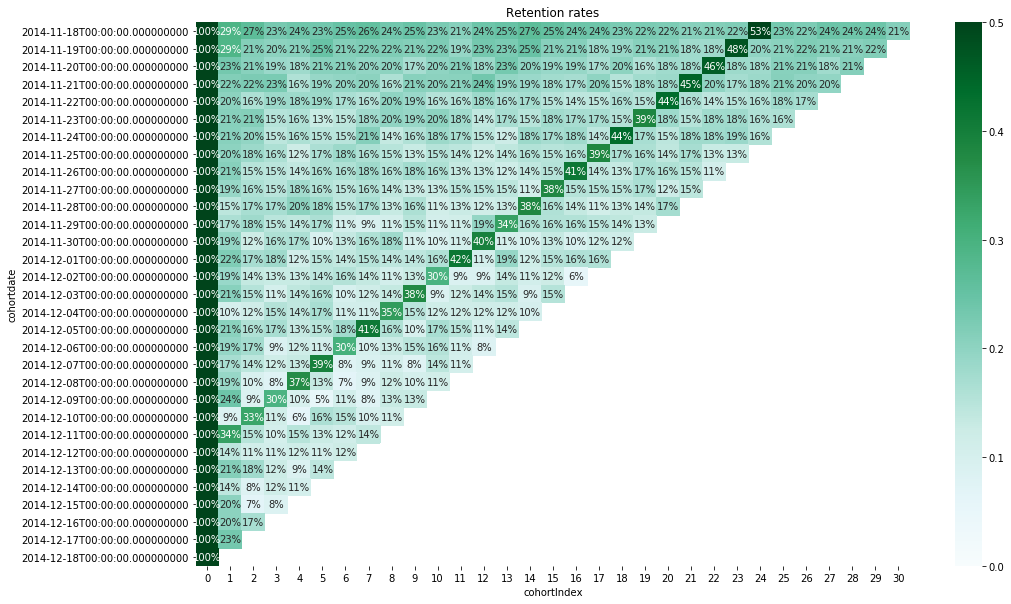

In [36]:
plt.figure(figsize=(16,10))
plt.title('Retention rates')
sns.heatmap(data=retention,annot=True,fmt='.0%',vmin=0.0,vmax=0.5,cmap='BuGn')
plt.show()

* 从上面的保留率热图可以看到，比如cohortdate2014-11-18，保留率最高的是24天后，为53%，即双十二那一天。通过此分析，公司可以了解并制定策略，以通过提供更具吸引力的折扣或进行更有效的营销来增加客户保留率。

## 7.使用RFM对用户进行分层

RFM分析是一种常用的技术，可以根据最近一次交易的最新程度（Recency），最近一年进行的交易次数（Frequency）以及每笔交易的货币价值（Monetary）为每个客户生成并分配分数。

RFM分析有助于回答一下问题：
* 谁是我们最近服务的客户？
* 他从我们的商店购买了多少次物品？
* 他的交易总价值是多少？
* 所有这些信息对于了解客户度公司的好坏至关重要。

获取RFM值后，一种常见的做法是在每个指标上创建“四分位数”并分配所需的顺序。例如假设我们将每个指标分为4个层次。
* 对于新近指标，最高值4将分配给新近度值最小的客户（因为他们是最近的客户）。
* 对于频率和货币指标，最高的价值4将分别分配给具有前25%频率和货币价值的客户。

在将指标划分为四分位数后，我们可以将指标记录到单个列中（如字符串“213”的形式），以此为客户创建RFM值类别。根据我们的要求，我们可以将RFM指标划分为更少或更多的层次。


注：因为源数据中没有提供有关Monetary的任何信息，所以虽然我们使用的是RFM模型方法，但是基于R和F两个维度的。

In [37]:
data_rfm=df.loc[df['behavior_type']==4,:]
data_rfm.reset_index(drop=True,inplace=True)
data_rfm.head()

,user_id,item_id,behavior_type,user_geohash,item_category,time,date,hour
0,101260672,73008997,4,NaN,4076,2014-11-25 13:00:00,2014-11-25,13
1,116730636,85319721,4,NaN,10079,2014-12-17 11:00:00,2014-12-17,11
2,104811265,61764614,4,NaN,675,2014-12-01 13:00:00,2014-12-01,13
3,106230218,238910858,4,NaN,12090,2014-12-03 11:00:00,2014-12-03,11
4,100684618,271840783,4,NaN,12220,2014-11-23 18:00:00,2014-11-23,18


定义一个snapshot_date。在这里，将snapshot_date定义为数据中的最高日期+1，即2014-12-19。(这样避免了“新近度”为0的情况)

In [38]:
snapshot_date=max(data_rfm.date)+dt.timedelta(days=1)
print('Snapshot date:{}'.format(snapshot_date.date()))

Snapshot date:2014-12-19


In [39]:
data=data_rfm.groupby(['user_id'],as_index=False).agg({'date':lambda x:(snapshot_date-x.max()).days,'time':'count'}).rename(columns={'date':'Recency','time':'Frequency'})

In [40]:
data

,user_id,Recency,Frequency
0,4913,3,6
1,6118,2,1
2,7528,6,6
3,7591,6,21
4,12645,5,8
5,54056,12,2
6,63348,8,1
7,79824,3,13
8,88930,2,23
9,100539,3,18


In [41]:
r_labels=range(4,0,-1)
# pd.qcut 按数据出现频率百分比划分
r_quartiles = pd.qcut(data['Recency'], 4, labels = r_labels)
data=data.assign(R=r_quartiles.values)

f_labels=range(1,5)
f_quartiles=pd.qcut(data['Frequency'],4,labels=f_labels)
data=data.assign(F=f_quartiles.values)

data.head()

,user_id,Recency,Frequency,R,F
0,4913,3,6,3,2
1,6118,2,1,4,1
2,7528,6,6,2,2
3,7591,6,21,2,4
4,12645,5,8,3,2


In [42]:
def join_rfm(x):
    return str(int(x['R']))+str(int(x['F']))
# 创建类别
data['RFM_Segment']=data.apply(join_rfm,axis=1)
data['RFM_Score']=data[['R','F']].sum(axis=1)
data.head()

,user_id,Recency,Frequency,R,F,RFM_Segment,RFM_Score
0,4913,3,6,3,2,32,5.0
1,6118,2,1,4,1,41,5.0
2,7528,6,6,2,2,22,4.0
3,7591,6,21,2,4,24,6.0
4,12645,5,8,3,2,32,5.0


In [43]:
data.groupby('RFM_Score').agg({'Recency':'mean','Frequency':'mean'}).round(1)

,Recency,Frequency
RFM_Score,,
2.0,18.6,2.1
3.0,10.3,4.2
4.0,7.4,6.3
5.0,5.0,8.9
6.0,3.7,13.9
7.0,2.4,20.8
8.0,1.4,39.2


我们可以在数据中手动创建类别，在RFM_Score=2-8的得分范围内创建细分：
* RFM_Score>=7的客户可以置于“Top”类别中；
* 4<=RFM_Score<7之间的客户可以放在“Middle”类别中；
* 剩下的属于“Low”类别

In [44]:
def create_segment(df):
    if df['RFM_Score']>=7:
        return 'Top'
    elif (df['RFM_Score']>=4) and (df['RFM_Score']<7):
        return 'Middle'
    else:
        return 'Low'
data['General_Segment']=data.apply(create_segment,axis=1)
data.groupby('General_Segment').agg({'Recency':'mean',
                                     'Frequency':'mean'}).round(1)

,Recency,Frequency
General_Segment,,
Low,15.0,3.0
Middle,5.3,9.8
Top,1.9,29.1


我们可以手动地创建这种细分逻辑，但是，如果我们想在RFM模型上找到合适的细分，也可以使用K-means等聚类算法。

K-means是一种聚类算法，常用于无监督学习任务。但是，该算法使有运用前提的，它要求数据满足一些假设条件。因此，我们需要对数据进行预处理，以使其能够满足算法的关键假设：
* 变量对称分布
* 变量应具有相似的平均值
* 变量应具有相似的标准差值

现在通过使用seaborn绘出新近度、频率的直方图来检查第一个假设：

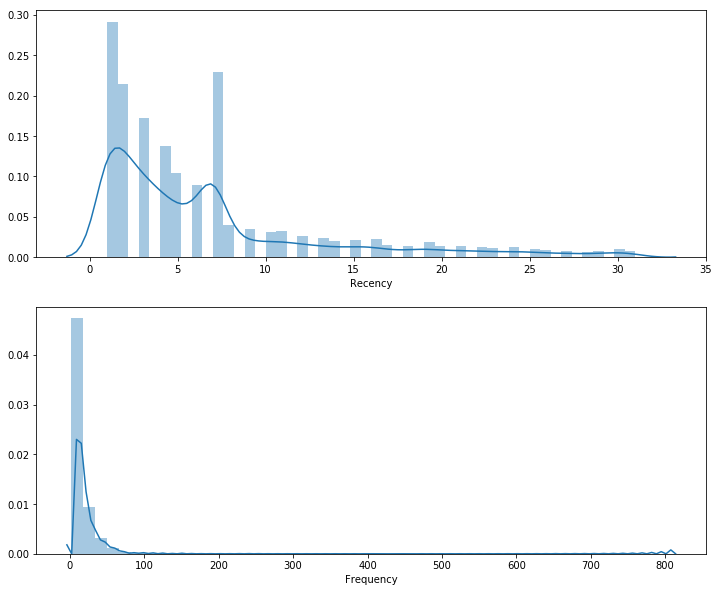

In [45]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1);sns.distplot(data['Recency'])
plt.subplot(2,1,2);sns.distplot(data['Frequency'])

从上图可以看出，R、F两个变量都不满足对称分布，它们都向右倾斜。要想消除偏斜，可以尝试一些转换方法。

这里使用对数转换。由于对数转换不能有负值，因此，如果存在负值，我们需要将其删除。这种情况下，一种常见做法是添加一个常数值以获得一个正值，通常将其视为没饿观察值变量最小负值的绝对值。但是，在我们的数据中没有负值。

首先将对数转化应用于数据，然后通过sklearn库中的StandardScaler()方法进行标准化。

In [46]:
raw_data=data[['Recency','Frequency']]

In [47]:
from sklearn.preprocessing import StandardScaler

# log转换
data_log=np.log(raw_data)

scaler=StandardScaler()
scaler.fit(data_log)

StandardScaler()

In [48]:
data_log

,Recency,Frequency
0,1.098612,1.791759
1,0.693147,0.000000
2,1.791759,1.791759
3,1.791759,3.044522
4,1.609438,2.079442
5,2.484907,0.693147
6,2.079442,0.000000
7,1.098612,2.564949
8,0.693147,3.135494
9,1.098612,2.890372


In [49]:
data_normalized=scaler.transform(data_log) # 这步有啥意义吗？
data_norm=pd.DataFrame(data=data_log,index=raw_data.index,columns=raw_data.columns)

In [50]:
data_norm

,Recency,Frequency
0,1.098612,1.791759
1,0.693147,0.000000
2,1.791759,1.791759
3,1.791759,3.044522
4,1.609438,2.079442
5,2.484907,0.693147
6,2.079442,0.000000
7,1.098612,2.564949
8,0.693147,3.135494
9,1.098612,2.890372


In [51]:
data_normalized

array([[-0.38900888, -0.25122767],
       [-0.80780489, -1.92119765],
       [ 0.32692763, -0.25122767],
       ...,
       [-1.5237414 , -0.42115646],
       [ 0.32692763,  1.51694126],
       [ 1.27334422,  0.46940695]])

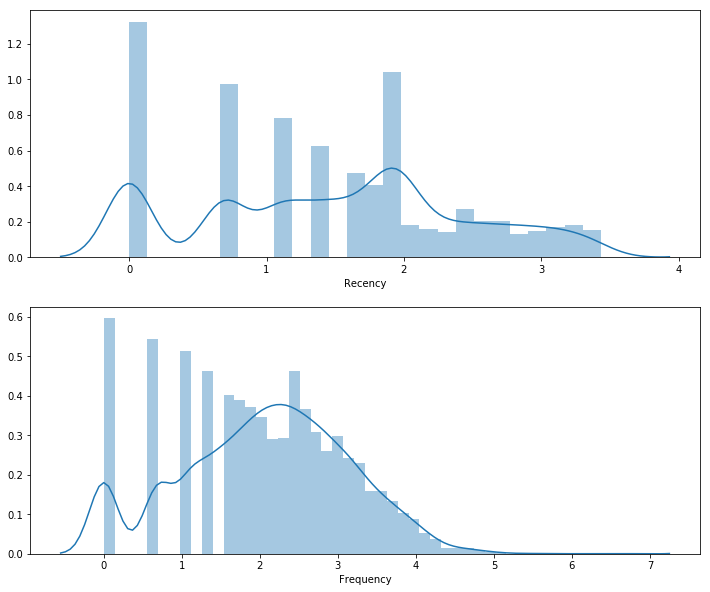

In [52]:
plt.figure(figsize=(12,10))
plt.subplot(2,1,1);sns.distplot(data_norm['Recency'])
plt.subplot(2,1,2);sns.distplot(data_norm['Frequency'])
plt.show()

虽然效果不太好，但是相比之下已经有所进步了。

接下来，我将基于规范化的RFM数据构建多个聚类，并使用肘部法则（elbow method）在我们的数据中找出最佳聚类数目。

In [53]:
from sklearn.cluster import KMeans

In [54]:
sse={}
for k in range(1,30):
    kmeans=KMeans(n_clusters=k,random_state=1)
    kmeans.fit(data_norm)
    sse[k]=kmeans.inertia_

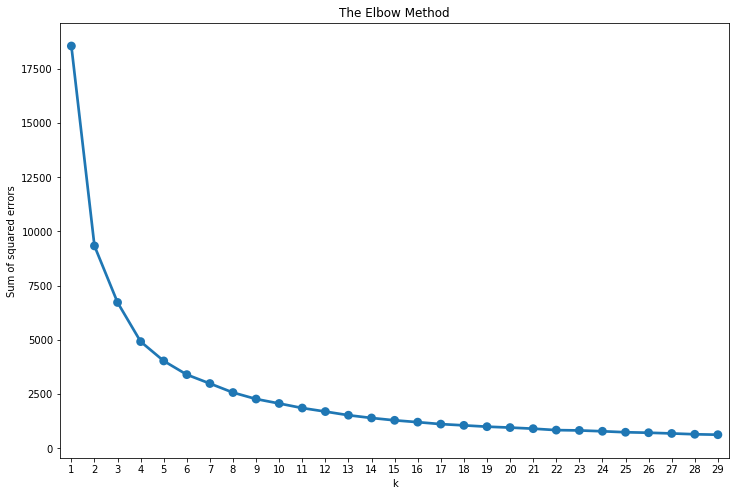

In [55]:
plt.figure(figsize=(12,8))
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('Sum of squared errors')
sns.pointplot(x=list(sse.keys()),y=list(sse.values()))
plt.show()

从上面的图中可以看出，最佳的聚类数是4或5。

先看一下聚类数为4时的情况。

In [57]:
kmeans=KMeans(n_clusters=4,random_state=1)
kmeans.fit(data_norm)
cluster_labels=kmeans.labels_

In [59]:
data_norm_k4=data_norm.assign(Cluster=cluster_labels)
data_k4=raw_data.assign(Cluster=cluster_labels)
summary_k4=data_k4.groupby(['Cluster']).agg({'Recency':'mean','Frequency':'mean'}).round(0)
summary_k4

,Recency,Frequency
Cluster,,
0,14.0,2.0
1,2.0,6.0
2,8.0,12.0
3,2.0,33.0


聚类为5时的情况。

In [60]:
kmeans=KMeans(n_clusters=5,random_state=1)
kmeans.fit(data_norm)
cluster_labels=kmeans.labels_

In [61]:
data_norm_k5=data_norm.assign(Cluster=cluster_labels)
data_k5=raw_data.assign(Cluster=cluster_labels)
summary_k5=data_k5.groupby(['Cluster']).agg({'Recency':'mean','Frequency':'mean'}).round(0)
summary_k5

,Recency,Frequency
Cluster,,
0,9.0,6.0
1,6.0,19.0
2,2.0,34.0
3,16.0,2.0
4,2.0,6.0


看一下二者的对比情况。

In [63]:
display(summary_k4)
display(summary_k5)

,Recency,Frequency
Cluster,,
0,14.0,2.0
1,2.0,6.0
2,8.0,12.0
3,2.0,33.0


,Recency,Frequency
Cluster,,
0,9.0,6.0
1,6.0,19.0
2,2.0,34.0
3,16.0,2.0
4,2.0,6.0


从上表中，我们可以比较4个和5个群集数据的新近度、频率的平均值的分布。但是，这样表现并不直观。

比较聚类划分的另一种常用方法是Snakeplots。它通常用于市场研究中以了解客户的看法。我下面以4个集群时的情况为例。

In [64]:
data_norm_k4.index=data['user_id'].astype(int)
data_norm_k4.head()

,Recency,Frequency,Cluster
user_id,,,
4913,1.098612,1.791759,1
6118,0.693147,0.000000,1
7528,1.791759,1.791759,2
7591,1.791759,3.044522,2
12645,1.609438,2.079442,2


In [65]:
# melt将多列数据进行融合
data_melt=pd.melt(data_norm_k4.reset_index(), #需要处理的数据集
                 id_vars=['user_id','Cluster'], #不需要被转换的列名
                 value_vars=['Frequency','Recency'], #需要转换的列名
                 var_name='Attribute', #自定义设置对应的列名
                 value_name='Value') #自定义设置对应的列名

In [68]:
data_melt.head(10)

,user_id,Cluster,Attribute,Value
0,4913,1,Frequency,1.791759
1,6118,1,Frequency,0.000000
2,7528,2,Frequency,1.791759
3,7591,2,Frequency,3.044522
4,12645,2,Frequency,2.079442
5,54056,0,Frequency,0.693147
6,63348,0,Frequency,0.000000
7,79824,2,Frequency,2.564949
8,88930,3,Frequency,3.135494
9,100539,3,Frequency,2.890372


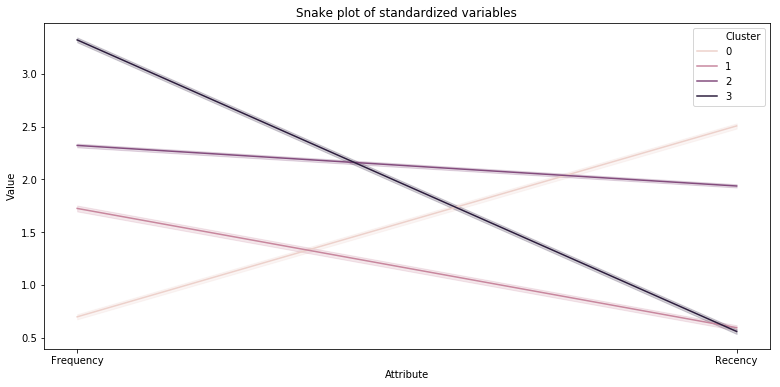

In [70]:
plt.figure(figsize=(13,6))
plt.title('Snake plot of standardized variables')
sns.lineplot(x='Attribute',y='Value',hue='Cluster',data=data_melt)

## 结论
我们应该通过RFM模型对客户进行细分后，给公司提出一些合理的建议，促进公司的业务增长。

| 集群 | 客户类型 | RFM模型解释 |建议 |
|---|---|---|---|
| 3 | 最佳客户 | R=2，F=33。最近两天有过购物记录，且购物频率高。| 公司应该为他们提供公司最新的产品，并进行多次宣传推销。大力度的折扣对于此类用户已经不是刚需。|
| 2 | 风险客户 | R=8，F=11。已有段时间没购物了，购物频率也不是很高。| 这类顾客处于即将流失的边缘，公司应该尝试着提供一些折扣，针对性地采取一些宣传措施。|
| 1 | 新客户 | R=2，F=6。最近有过购物记录，且频率还不错。| 谨慎对待这些客户，并努力提升和他们之间的关系，尝试增强他们的购物体验感，提供优质的产品和服务。|
| 0 | 流失客户 | R=15，F=2。已经很久没有购物了，并且频率较低。| 这类客户几乎不再购物了，公司应该要找出他们流失的原因，以防止此类问题再次发生。|